In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [18]:
def train_loop_perclass(experiment):
    accs = [] # test loss
    ent = [] # entropy
    class_acc = []
    t_acc = []
    grads = []

    np.random.seed(np.random.randint(0,100))
    train_labels = np.reshape(np.random.permutation(np.arange(1,11)), (5,2))

    indices = []
    epoch = 1
    for label in train_labels:
        print("training on class {}".format(label))

        indices = np.hstack([0,np.delete(train_labels,np.where(train_labels==label)[0],axis=0).flatten()])

        experiment.train(epoch, label, indices)   
        mt = experiment.test()
        t_acc.append(mt["mean_accuracy"])

        ct = [experiment.test_class(k)["mean_accuracy"] for k in range(1,11)]
        class_acc.append(ct)

        t = experiment.test()
        print("Mean accuracy: {}".format(t["mean_accuracy"]))

        accs.append(t["mean_accuracy"])
        ent.append(np.round(t["entropy"]))
        
    return class_acc, accs, ent, train_labels

In [32]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"

corrs = []
dotproducts = []

exp = "sparseCNN2"
config_init = parse_config(config_file)
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["data_dir"] = data_dir
config["batch_size"] = 32
config["num_classes"] = 11

config["freeze_params"] = []

experiment = ContinuousSpeechExperiment(config=config)

model on GPU
Creating optimizer with learning rate= 0.01


In [45]:
for ind in range(2):
    class_acc, accs, ent, train_labels = train_loop_perclass(experiment)

training on class [10  2]
Mean accuracy: 23.393416927899686
training on class [9 4]
Mean accuracy: 34.71786833855799
training on class [3 1]
Mean accuracy: 30.56426332288401
training on class [5 7]
Mean accuracy: 32.24921630094044
training on class [8 6]
Mean accuracy: 27.82131661442006
training on class [9 6]
Mean accuracy: 28.996865203761757
training on class [5 3]
Mean accuracy: 29.663009404388713
training on class [7 8]
Mean accuracy: 27.86050156739812
training on class [ 1 10]
Mean accuracy: 31.93573667711599
training on class [4 2]
Mean accuracy: 33.11128526645768


In [40]:
act = {}
def get_act(name):
    def hook(model, input_, output):
        act[name] = output.detach().cpu().numpy()
    return hook
 
cnt = 0
layer_list = list(experiment.model.named_children())
k = [x[0] for x in layer_list]

for module in experiment.model:
    module.register_forward_hook(get_act(k[cnt]))
    cnt += 1

outputs = []
for k in range(1,11):
    act = {}
    loader = experiment.test_loader[k]
    x,_ = next(iter(loader))
    experiment.model(x.cuda())
    outputs.append(act)

all_keys = outputs[0].keys()
print(all_keys)

dict_keys(['cnn1_cnn', 'cnn1_bn', 'cnn1_kwinner', 'cnn1_maxpool', 'cnn2_cnn', 'cnn2_bn', 'cnn2_kwinner', 'cnn2_maxpool', 'flatten', 'linear1', 'linear1_bn', 'linear1_kwinners', 'linear2', 'linear2_bn', 'linear2_relu', 'softmax'])


In [122]:
outputs[0]['output'].shape

(32, 11)

In [41]:
key = 'softmax'
mod_output = [np.vstack([outputs[n][key][k,:].flatten() for k in range(experiment.batch_size)]).flatten()
              for n in range(len(outputs))]

0.0021178823305881855


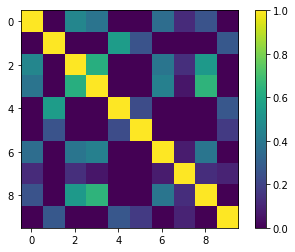

In [42]:
cc = np.corrcoef(np.vstack(mod_output))
plt.imshow(cc)
plt.clim((0., 1.))
plt.colorbar()
print(np.triu(cc,1).mean())

8


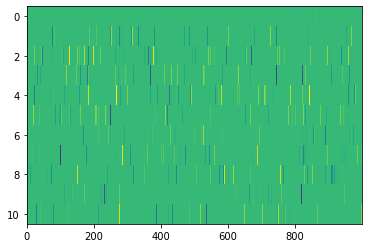

In [43]:
weights = list(experiment.model.named_parameters())
print(len(weights))
w = weights[6][1].detach().cpu().numpy()
plt.imshow(w, aspect="auto")

In [112]:
w[np.hstack(train_labels),:].shape

(10, 1000)

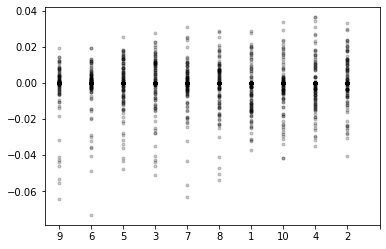

In [44]:
plt.plot(w[np.hstack(train_labels),:],'k.', alpha=0.2);
plt.xticks(range(11),np.hstack(train_labels));

In [62]:
[len(np.where(k.flatten() > 0)[0]) / k.size for k in mod_output]

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

In [67]:
fcorrs = [[corrs[0][k] for k in [0,4,9,2,6,11]],
          [corrs[1][k] for k in [0,4,9,2,6,11]],
          [corrs[2][k] for k in [0,4,9,2,6,11]],
          [corrs[3][k] for k in [0,4,9,2,6,11]]
         ]

fdots = [[dotproducts[0][k] for k in [0,4,9,2,6,11]],
          [dotproducts[1][k] for k in [0,4,9,2,6,11]],
          [dotproducts[2][k] for k in [0,4,9,2,6,11]],
          [dotproducts[3][k] for k in [0,4,9,2,6,11]]
         ]

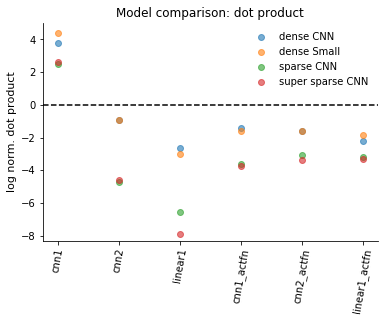

In [70]:
module_keys = ["cnn1", "cnn2", "linear1", "cnn1_actfn", "cnn2_actfn", "linear1_actfn"]
fig, ax = plt.subplots()
ax.plot(np.log(fdots[0]),'o', alpha=0.6)
ax.plot(np.log(fdots[1]),'o', alpha=0.6)
ax.plot(np.log(fdots[2]),'o', alpha=0.6)
ax.plot(np.log(fdots[3]),'o', alpha=0.6)

plt.xticks(range(6), module_keys, rotation=80)
plt.ylim((-8.3, 5))
plt.title("Model comparison: dot product")
plt.axhline([0], color="k", linestyle="--")
plt.ylabel("log norm. dot product", fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(["dense CNN", "dense Small", "sparse CNN", "super sparse CNN"], frameon=False)
plt.savefig("../plots/permodel_dotprod_perclass.tiff", bbox_inches="tight")

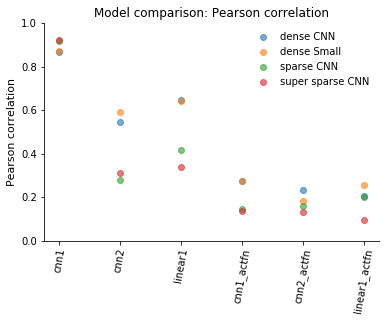

In [71]:
module_keys = ["cnn1", "cnn2", "linear1", "cnn1_actfn", "cnn2_actfn", "linear1_actfn"]
fig, ax = plt.subplots()
ax.plot(fcorrs[0],'o', alpha=0.6)
ax.plot(fcorrs[1],'o', alpha=0.6)
ax.plot(fcorrs[2],'o', alpha=0.6)
ax.plot(fcorrs[3],'o', alpha=0.6)

plt.xticks(range(6), module_keys, rotation=80)
plt.ylim((0., 1.))
plt.title("Model comparison: Pearson correlation")
plt.ylabel("Pearson correlation", fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(["dense CNN", "dense Small", "sparse CNN", "super sparse CNN"], frameon=False)
plt.savefig("../plots/permodel_pearson_perclass.tiff", bbox_inches="tight")

In [6]:
np.save("../plots/correlations_models_perclass.npy", corrs)
np.save("../plots/dotprods_models_perclass.npy", dotproducts)

In [2]:
def register_act(model):
    cnt = 0
    layer_list = list(model.named_children())
    k = [x[0] for x in layer_list]
    
    act = {}
    def get_act(name):
        def hook(model, input_, output):
            act[name] = output.detach().cpu().numpy()
        return hook

    for module in model:
        module.register_forward_hook(get_act(k[cnt]))
        cnt += 1

    outputs = []
    for k in range(1,11):
        act = {}
        loader = experiment.test_loader[k]
        x,_ = next(iter(loader))
        model(x.cuda())
        outputs.append(act)

    all_keys = outputs[0].keys()
    print(all_keys)
    
    corr_mats = []
    dot_mats = []
    for key in all_keys:
        mod_output = [np.vstack([outputs[n][key][k,:].flatten() for k in range(experiment.batch_size)])
                      for n in range(len(outputs))]

        corr_mat = np.zeros((10,10))
        iu = np.triu_indices(experiment.batch_size,1)
        dot_mat = np.zeros((10,10))

        m_len = mod_output[0].shape[1]

        for i in range(10):
            for j in range(10):
                corr_mat[i,j] = np.corrcoef(mod_output[i], mod_output[j])[iu].mean()

                dot_mat[i,j] = np.mean([np.dot(mod_output[i][x,:],mod_output[j][y,:])/m_len
                                        for x in range(experiment.batch_size) for y in range(experiment.batch_size)])

        corr_mats.append(corr_mat)
        dot_mats.append(dot_mat)
    
    
    ids = np.triu_indices(10,0)
    ccs = [np.mean(np.triu(k,0)[ids]) for k in corr_mats]
    ds = [np.mean(np.triu(k,0)[ids]) for k in dot_mats]

    return ccs, ds


In [47]:
corr_mats = []
dot_mats = []

for key in all_keys:
    mod_output = [np.vstack([outputs[n][key][k,:].flatten() for k in range(experiment.batch_size)])
                  for n in range(len(outputs))]

    corr_mat = np.zeros((10,10))
    iu = np.triu_indices(experiment.batch_size,1)
    dot_mat = np.zeros((10,10))
    
    m_len = mod_output[0].shape[1]

    for i in range(10):
        for j in range(10):
            corr_mat[i,j] = np.corrcoef(mod_output[i], mod_output[j])[iu].mean()
            
            dot_mat[i,j] = np.mean([np.dot(mod_output[i][x,:],mod_output[j][y,:])/m_len
                                    for x in range(experiment.batch_size) for y in range(experiment.batch_size)])
            
    corr_mats.append(corr_mat)
    dot_mats.append(dot_mat)
    


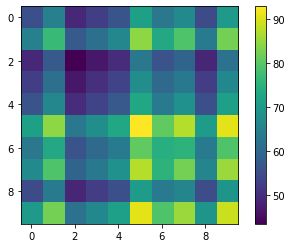

In [48]:
plt.imshow(dot_mat)
plt.colorbar()

In [72]:
np.triu(dot_mat,0)
ids = np.triu_indices(10,0)
np.mean(np.triu(dot_mat,0)[ids])

66.33581834878804

In [49]:
ccs = [np.mean(np.triu(k,1)) for k in corr_mats]

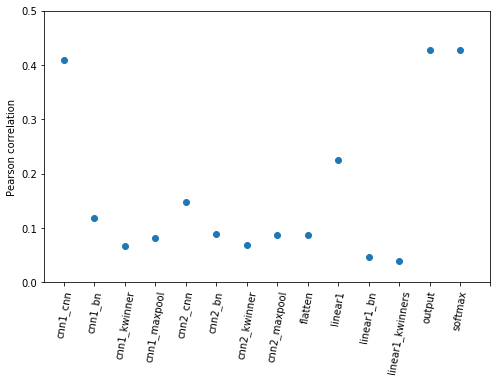

In [50]:
plt.figure(figsize=(8,5))
plt.plot(ccs, 'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylim((0., 0.5))
plt.ylabel("Pearson correlation")
plt.savefig("../plots/{}_{}_pearson_2cpe_2pctgrad.jpg".format(config["cnn_out_channels"][0], config["cnn_out_channels"][1]))

In [51]:
ds = [np.mean(np.triu(k,0)) for k in dot_mats]

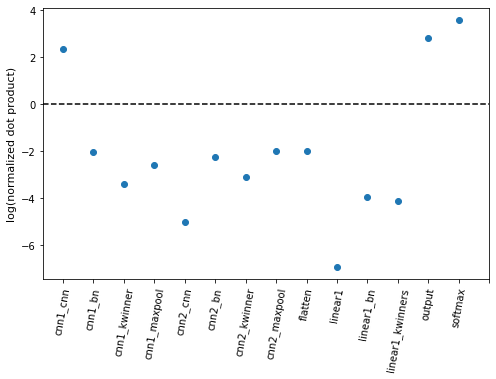

In [52]:
plt.figure(figsize=(8,5))
plt.plot(np.log(ds), 'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylabel("log(normalized dot product)", fontsize=11)
# plt.ylim((-7, 5))
plt.axhline(0, color='k', linestyle='--')
plt.savefig("../plots/{}_{}_dotp_2cpe_2pctgrad.jpg".format(config["cnn_out_channels"][0], config["cnn_out_channels"][1]))

In [39]:
torch.index_select?

In [86]:
experiment.model

LeSparseNet(
  (cnn1_cnn): SparseWeights2d(
    weight_sparsity=0.5
    (module): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn1_kwinner): KWinners2d(channels=64, local=False, n=50176, percent_on=0.095, boost_strength=0.8857348561286926, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_cnn): SparseWeights2d(
    weight_sparsity=0.2
    (module): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn2_kwinner): KWinners2d(channels=64, local=False, n=6400, percent_on=0.125, boost_strength=0.8857348561286926, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [158]:
1

1

In [22]:
os.mkdir("../plots")

In [53]:
experiment.freeze_params

'output'